<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/AnoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# パッケージのimport
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

#### データセット(MNIST)の確認

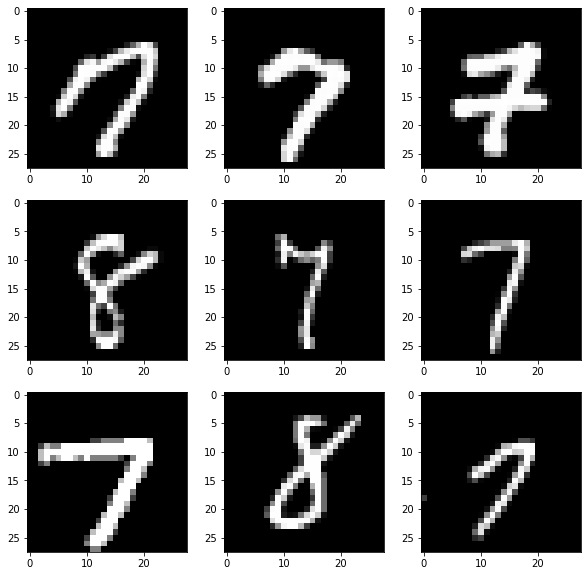

In [2]:
# MNIST の読み込み
train = pd.read_csv("./sample_data/mnist_train_small.csv", dtype=np.float32)
train.rename(columns={"6": "label"}, inplace=True)
test = pd.read_csv("./sample_data/mnist_test.csv", dtype=np.float32)
test.rename(columns={"7": "label"}, inplace=True)

# 学習データとして、7 と 8 の画像を合わせて400枚使用する
train = train.query("label in [7.0, 8.0]").head(400)

# テストデータとして、2, 7, 8 の画像を合わせて600枚使用する
test = test.query("label in [2.0, 7.0, 8.0]").head(600)

# ラベル(1列目)を削除
train = train.iloc[:, 1:].values.astype("float32")
test = test.iloc[:, 1:].values.astype("float32")

# 28×28 の行列に変換
train = train.reshape(train.shape[0], 28, 28)
test = test.reshape(test.shape[0], 28, 28)

# データの確認
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(330 + (i + 1))
    plt.imshow(train[i], cmap=plt.get_cmap("gray"))

#### AnoGAN
論文: https://arxiv.org/pdf/1703.05921.pdf

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def CBA(
            in_channel,
            out_channel,
            kernel_size=4,
            stride=2,
            padding=1,
            activation=nn.ReLU(inplace=True),
            bn=True,
        ):
            seq = []
            seq += [
                nn.ConvTranspose2d(
                    in_channel,
                    out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            ]
            if bn is True:
                seq += [nn.BatchNorm2d(out_channel)]
            seq += [activation]

            return nn.Sequential(*seq)

        seq = []
        seq += [CBA(20, 64 * 8, stride=1, padding=0)]
        seq += [CBA(64 * 8, 64 * 4)]
        seq += [CBA(64 * 4, 64 * 2)]
        seq += [CBA(64 * 2, 64)]
        seq += [CBA(64, 1, activation=nn.Tanh(), bn=False)]

        self.generator_network = nn.Sequential(*seq)

    def forward(self, z):
        out = self.generator_network(z)

        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def CBA(
            in_channel,
            out_channel,
            kernel_size=4,
            stride=2,
            padding=1,
            activation=nn.LeakyReLU(0.1, inplace=True),
        ):
            seq = []
            seq += [
                nn.Conv2d(
                    in_channel,
                    out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                )
            ]
            seq += [nn.BatchNorm2d(out_channel)]
            seq += [activation]

            return nn.Sequential(*seq)

        seq = []
        seq += [CBA(1, 64)]
        seq += [CBA(64, 64 * 2)]
        seq += [CBA(64 * 2, 64 * 4)]
        seq += [CBA(64 * 4, 64 * 8)]
        self.feature_network = nn.Sequential(*seq)

        self.critic_network = nn.Conv2d(64 * 8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.feature_network(x)

        feature = out
        feature = feature.view(feature.size(0), -1)

        out = self.critic_network(out)

        return out, feature

#### モデルの学習

In [5]:
class image_data_set(Dataset):
    def __init__(self, data):
        self.images = data[:, :, :, None]
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize(64, interpolation=Image.BICUBIC),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.transform(self.images[idx])


train_set = image_data_set(train)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [6]:
# GPU or CPU の指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの読み込み
G = Generator().to(device)
D = Discriminator().to(device)

# モデルを学習モードに設定
G.train()
D.train()

# オプティマイザの設定
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0004, betas=(0.0, 0.9))

# 学習時の損失関数の定義
criterion = nn.BCEWithLogitsLoss(reduction="mean")

1.   Generatorで潜在変数から偽の画像を作る
2.   偽の画像と本物の画像を分類できるようにDiscriminatorを学習
3.   Generatorで潜在変数から偽の画像を作る
4.   Discriminatorの分類結果が誤るようにGeneratorを学習

In [7]:
# 学習の実行
for epoch in range(300):
    # 損失の推移を確認するための変数を定義
    log_g_loss, log_d_loss = 0.0, 0.0
    for images in train_loader:
        images = images.to(device)

        ## Discriminatorの学習
        # 真偽のラベルを定義
        label_real = torch.full((images.size(0),), 1.0).to(device)
        label_fake = torch.full((images.size(0),), 0.0).to(device)

        # Generator を用いて潜在変数から偽の画像を生成
        z = (
            torch.randn(images.size(0), 20)
            .to(device)
            .view(images.size(0), 20, 1, 1)
            .to(device)
        )
        fake_images = G(z)

        # Discriminator で偽の画像と本物の画像を判定
        d_out_real, _ = D(images)
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # 誤差逆伝播法で勾配の計算、重みの更新
        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        ## Generator の学習
        # 潜在変数から偽の画像を生成
        z = (
            torch.randn(images.size(0), 20)
            .to(device)
            .view(images.size(0), 20, 1, 1)
            .to(device)
        )
        fake_images = G(z)

        # Discriminator によって真偽判定
        d_out_fake, _ = D(fake_images)

        # 損失の計算
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # 誤差逆伝播法で勾配の計算、重みの更新
        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()

        ## 損失の推移の記録
        log_d_loss += d_loss.item()
        log_g_loss += g_loss.item()

    print(f"epoch {epoch}, D_Loss:{log_d_loss/128:.4f}, G_Loss:{log_g_loss/128:.4f}")

epoch 0, D_Loss:0.0274, G_Loss:0.1757
epoch 1, D_Loss:0.0183, G_Loss:0.1841
epoch 2, D_Loss:0.0018, G_Loss:0.1549
epoch 3, D_Loss:0.0012, G_Loss:0.1671
epoch 4, D_Loss:0.0007, G_Loss:0.1753
epoch 5, D_Loss:0.0005, G_Loss:0.1941
epoch 6, D_Loss:0.0003, G_Loss:0.1912
epoch 7, D_Loss:0.0003, G_Loss:0.2093
epoch 8, D_Loss:0.0002, G_Loss:0.2135
epoch 9, D_Loss:0.0001, G_Loss:0.2303
epoch 10, D_Loss:0.0001, G_Loss:0.2331
epoch 11, D_Loss:0.0001, G_Loss:0.2488
epoch 12, D_Loss:0.0001, G_Loss:0.2516
epoch 13, D_Loss:0.0000, G_Loss:0.2681
epoch 14, D_Loss:0.0000, G_Loss:0.2727
epoch 15, D_Loss:0.0000, G_Loss:0.2831
epoch 16, D_Loss:0.0000, G_Loss:0.2903
epoch 17, D_Loss:0.0000, G_Loss:0.2964
epoch 18, D_Loss:0.0000, G_Loss:0.3035
epoch 19, D_Loss:0.0000, G_Loss:0.3173
epoch 20, D_Loss:0.0000, G_Loss:0.3255
epoch 21, D_Loss:0.0000, G_Loss:0.3330
epoch 22, D_Loss:0.0000, G_Loss:0.3486
epoch 23, D_Loss:0.0000, G_Loss:0.3507
epoch 24, D_Loss:0.0000, G_Loss:0.3601
epoch 25, D_Loss:0.0000, G_Loss:0.3

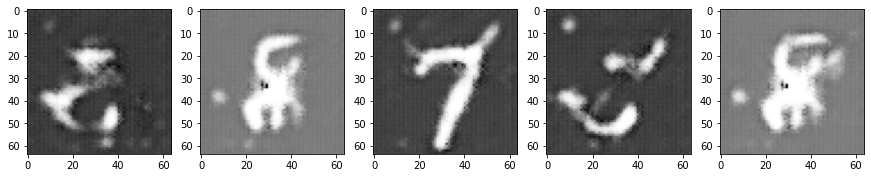

In [8]:
z = torch.randn(8, 20).to(device).view(8, 20, 1, 1).to(device)
fake_images = G(z)

# 出力
fig = plt.figure(figsize=(15, 3))
for i in range(0, 5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), "gray")